## 1. FOPDT Simulation for Generating training Data

In [1]:
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

     |████████████████████████████████| 12.4 MB 60 kB/s 


In [2]:
# from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump

import tensorflow as tf

# from smt.sampling_methods import LHS
# from smt.sampling_methods import Random

In [3]:
#%% Mount Google drive if you use colab for save and load LSTM models
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')
    
else:
  print('Not running on Colab')

Running on Colab
Mounted at /content/drive


In [74]:
tfinal = 30 # fianl time

In [75]:
m=GEKKO(remote=False)
m.time = np.linspace(0,tfinal-1,tfinal)

In [76]:
K = m.FV(1) # Process Gain
tau = m.FV(2) # Time Constant

In [77]:
u_input = np.zeros(tfinal)
u_input[5:] = 1

In [78]:
y = m.CV()
u = m.MV(u_input)
m.Equation(tau*y.dt()+y==K*u) #FOPDT Equation

m.options.IMODE=4

In [79]:
m.solve(disp=False)

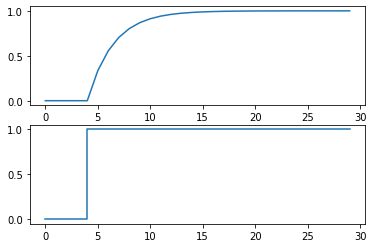

In [80]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(m.time, y)
plt.subplot(2,1,2)
plt.plot(m.time, u, drawstyle='steps')
plt.show()

## 2. Generating input signal (Full Random and LHS)

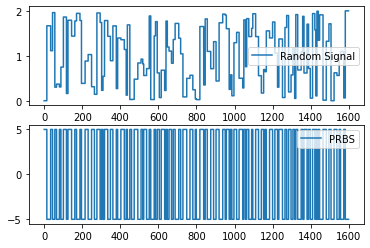

In [81]:
import numpy as np
import matplotlib.pyplot as plt

nstep = 1600 # Choose training data length

# random signal generation

a_range = [0,2]
a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
a[0] = 0

b_range = [5, 20]
b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
b = np.round(b)
b = b.astype(int)

b[0] = 0

for i in range(1,np.size(b)):
    b[i] = b[i-1]+b[i]

# Random Signal
i=0
random_signal = np.zeros(nstep)
while b[i]<np.size(random_signal):
    k = b[i]
    random_signal[k:] = a[i]
    i=i+1

# PRBS
a = np.zeros(nstep)
j = 0
while j < nstep:
    a[j] = 5
    a[j+1] = -5
    j = j+2

i=0
prbs = np.zeros(nstep)
while b[i]<np.size(prbs):
    k = b[i]
    prbs[k:] = a[i]
    i=i+1

plt.figure(0) 
plt.subplot(2,1,1)
plt.plot(random_signal, drawstyle='steps',label='Random Signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(prbs, drawstyle='steps', label='PRBS')
plt.legend()
plt.show()

## 3. Evaluate the Random Input Signal

In [82]:
tfinal = nstep
m.time = np.linspace(0,tfinal-1,tfinal)
u.value = random_signal

In [83]:
m.options.IMODE = 4
m.solve(disp=False)

In [84]:
data = pd.DataFrame(
        {"u": u,
         "y": y},
        index = np.linspace(1,nstep,nstep,dtype=int))

In [85]:
data.to_pickle('/content/drive/MyDrive/Transformer_MPC/FOPDT/open_loop_data_SISO.pkl')

In [86]:
# unpickled = pd.read_pickle('/content/drive/MyDrive/Transformer_MPC/FOPDT/open_loop_data_SISO.pkl')

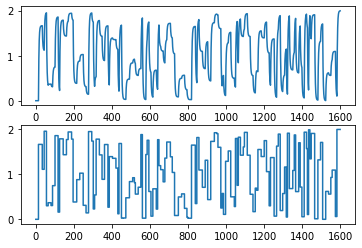

In [87]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(m.time, data["y"])
plt.subplot(2,1,2)
plt.plot(m.time, data["u"], drawstyle='steps')
plt.show()

## 4. Train LSTM Network

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import time

In [89]:
# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [90]:
window = 5
#Load training data
data = pd.DataFrame(
        {"u": u,
         "y": y},
        index = np.linspace(1,nstep,nstep,dtype=int))

In [91]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['u','y']])
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['y']])

In [92]:
Ys.shape

(1600, 1)

In [93]:
Xs.shape

(1600, 2)

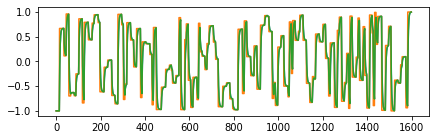

In [94]:
plt.figure(figsize=[7,2])
plt.plot(Ys)
plt.plot(Xs)

In [95]:
#%% Save MinMaxScaler file
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  joblib.dump(s1, '/content/drive/MyDrive/Transformer_MPC/FOPDT/LSTM_MPC/s1.sav')
  joblib.dump(s2, '/content/drive/MyDrive/Transformer_MPC/FOPDT/LSTM_MPC/s2.sav')
    
else:
  print('Not running on Colab')
  joblib.dump(s1, 's1.sav')
  joblib.dump(s2, 's2.sav')

Running on Colab


In [96]:
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

800


In [97]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)):
    X_train.append(Xs_train[i-window:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)):
    X_val.append(Xs_val[i-window:i,:])
    Y_val.append(Ys_val[i])


In [98]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [99]:
np.shape(X_train), np.shape(Y_train)

((795, 5, 2), (795, 1))

In [100]:
Y_train.shape[1]

1

In [101]:
# # Initialize LSTM model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

In [102]:
# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(X_train, Y_train, epochs = 300, batch_size = 250, callbacks=[es], verbose=1, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Epoch 1/300
4/4 [==============================] - 6s 400ms/step - loss: 0.3185 - accuracy: 0.0000e+00 - val_loss: 0.2518 - val_accuracy: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 25ms/step - loss: 0.2114 - accuracy: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0965 - accuracy: 0.0000e+00 - val_loss: 0.1213 - val_accuracy: 0.0013
Epoch 4/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0995 - accuracy: 0.0000e+00 - val_loss: 0.1145 - val_accuracy: 0.0013
Epoch 5/300
4/4 [==============================] - 0s 25ms/step - loss: 0.0788 - accuracy: 0.0000e+00 - val_loss: 0.0860 - val_accuracy: 0.0013
Epoch 6/300
4/4 [==============================] - 0s 25ms/step - loss: 0.0724 - accuracy: 0.0000e+00 - val_loss: 0.0873 - val_accuracy: 0.0013
Epoch 7/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0698 - accuracy: 0.0000e+00 - val_loss: 0.0793 - val_

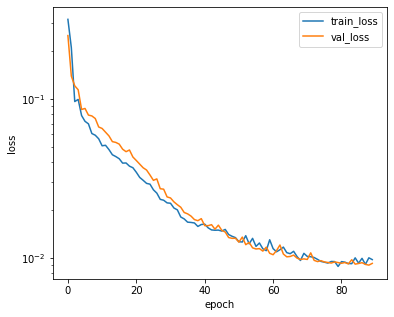

In [103]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(history.history['loss'],label='train_loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss')
# plt.savefig('FOPDT_loss.png')
plt.legend()

In [104]:
#%% Save model file
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model.save('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
    
else:
  print('Not running on Colab')
  model.save('model.h5')

Running on Colab


## 2. Transformer

In [115]:
n_feature = X_train.shape[2]

encoder_input = tf.keras.layers.Input(shape=(window, n_feature))
hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = hl_mha + encoder_input
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*n_feature, activation="tanh")(res)
hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
res = hl_mha + encoder_input
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*n_feature, activation="tanh")(res)
hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
res = hl_mha + encoder_input
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*n_feature, activation="tanh")(res)
hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
res = hl_mha + encoder_input
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*n_feature, activation="tanh")(res)
hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
res = hl_mha + encoder_input
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*n_feature, activation="tanh")(res)
hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
res = hl_mha + encoder_input
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*n_feature, activation="tanh")(res)
hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)

hl_mha = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(hl_mha,hl_mha)
res = hl_mha + encoder_input
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = 4*n_feature, activation="tanh")(res)
hl_mha = tf.keras.layers.Dropout(0.1)(hl_mha)
hl_mha = tf.keras.layers.Conv1D(kernel_size = 1, filters = encoder_input.shape[-1])(hl_mha)
# hl_mha = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hl_mha)



# hl_mha = tf.keras.layers.Dense(5, activation='relu')(hl_mha)
# hl_mha = tf.keras.layers.Dense(3, activation=None)(hl_mha)
hl_mha = tf.keras.layers.Flatten()(hl_mha)
output_layer_mha = tf.keras.layers.Dense(Y_train.shape[1], activation='linear')(hl_mha)
model_mha = tf.keras.Model(inputs=encoder_input, outputs=output_layer_mha, name="mhl")

model_mha.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

t0 = time.time()
result_mha = model_mha.fit(X_train,Y_train,epochs=300,batch_size=32, callbacks=[es], verbose=1, validation_data=(X_val, Y_val))
t2 = time.time()

print('Runtime: %.2f s' %(t2-t0))


Epoch 1/300
25/25 [==============================] - 4s 48ms/step - loss: 0.9610 - accuracy: 0.0000e+00 - val_loss: 0.4978 - val_accuracy: 0.0000e+00
Epoch 2/300
25/25 [==============================] - 1s 26ms/step - loss: 0.2330 - accuracy: 0.0000e+00 - val_loss: 0.1799 - val_accuracy: 0.0013
Epoch 3/300
25/25 [==============================] - 1s 27ms/step - loss: 0.1411 - accuracy: 0.0000e+00 - val_loss: 0.1444 - val_accuracy: 0.0013
Epoch 4/300
25/25 [==============================] - 1s 25ms/step - loss: 0.1075 - accuracy: 0.0000e+00 - val_loss: 0.1128 - val_accuracy: 0.0013
Epoch 5/300
25/25 [==============================] - 1s 27ms/step - loss: 0.0876 - accuracy: 0.0000e+00 - val_loss: 0.0657 - val_accuracy: 0.0013
Epoch 6/300
25/25 [==============================] - 1s 27ms/step - loss: 0.0539 - accuracy: 0.0000e+00 - val_loss: 0.0414 - val_accuracy: 0.0013
Epoch 7/300
25/25 [==============================] - 1s 26ms/step - loss: 0.0457 - accuracy: 0.0000e+00 - val_loss: 0.04

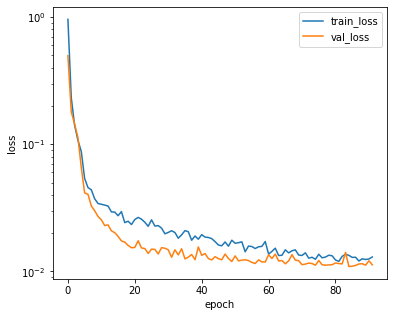

In [116]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(result_mha.history['loss'],label='train_loss')
plt.semilogy(result_mha.history['val_loss'],label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss')
# plt.savefig('FOPDT_loss.png')
plt.legend()

## 5. Using measured values to predict next step

In [107]:
# if 'google.colab' in str(get_ipython()):
#   print('Running on Colab')
#   model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  
# else:
#   print('Not running on Colab')
#   model = load_model('model.h5')

In [108]:
Yp_train_lstm = model.predict(X_train)

In [109]:
Yp_train_transformer = model_mha.predict(X_train)

In [110]:
np.shape(Yp_train)

(795, 1)

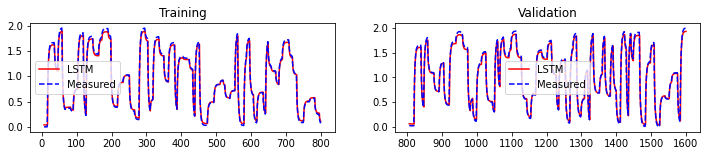

In [113]:
# Verify the fit of the model
Yp_train_lstm = model.predict(X_train)
Yp_val_lstm = model.predict(X_val)

# un-scale outputs
Yu_train_lstm = s2.inverse_transform(Yp_train_lstm)
Ym_train_lstm = s2.inverse_transform(Y_train)

Yu_val_lstm = s2.inverse_transform(Yp_val_lstm)
Ym_val_lstm = s2.inverse_transform(Y_val)

plt.figure(0, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index],Yu_train_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train_lstm[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:],Yu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val_lstm[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()

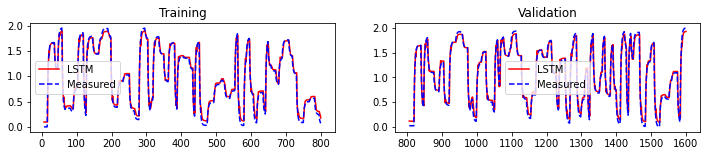

In [117]:
# Verify the fit of the model
Yp_train_transformer = model_mha.predict(X_train)
Yp_val_transformer = model_mha.predict(X_val)

# un-scale outputs
Yu_train_transformer = s2.inverse_transform(Yp_train_transformer)
Ym_train_transformer = s2.inverse_transform(Y_train)

Yu_val_transformer = s2.inverse_transform(Yp_val_transformer)
Ym_val_transformer = s2.inverse_transform(Y_val)

plt.figure(0, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index],Yu_train_transformer[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train_transformer[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:],Yu_val_transformer[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val_transformer[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()

## 6. Using predicted values to predict next step

In [41]:
# Load model files (LSTM and MinMaxScaler)
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model = load_model('/content/drive/MyDrive/Transformer_MPC/FOPDT/LSTM_MPC/model.h5')
  s1 = joblib.load('/content/drive/MyDrive/Transformer_MPC/FOPDT/LSTM_MPC/s1.sav')
  s2 = joblib.load('/content/drive/MyDrive/Transformer_MPC/FOPDT/LSTM_MPC/s2.sav')
  
else:
  print('Not running on Colab')
  model = load_model('model.h5')
  s1 = joblib.load('s1.sav')
  s2 = joblib.load('s2.sav')

Running on Colab


In [42]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_train = Ytu[window:cut_index]
Ytu_val = Ytu[cut_index+window:]

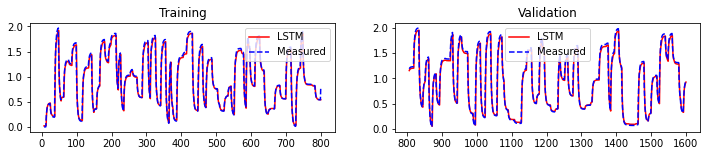

In [43]:
plt.figure(0, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index],Ytu_train[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:],Ytu_val[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()